In [ ]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.chdir("/home/bnet/litalv/MLHC/model")

In [ ]:
import pandas as pd
import numpy as np
import pickle as pkl

import matplotlib.pyplot as plt

from project.model.trainning import train_multitask_seq_ae
from project.model.prediction import predict_proba, encode_embeddings, predict_proba_knn, predict_logits, fit_calibrators, predict_proba_calibrated,fit_isotonic_calibrators, predict_isotonic_proba_calibrated
from project.model.utils.eval_results import eval_multitask_from_probs, plot_running_total_subplots, plot_running_total, plot_calibration_curve
from project.model.utils.feature_importance import feature_importance

# Read dataSets

In [4]:
with open(f"data/X_train_seq.pkl", 'rb') as f:
	X_train = pkl.load(f)
with open(f"data/y_train_lables.pkl", 'rb') as f:
	y_train = pkl.load(f)
with open(f"data/mask_train.pkl", 'rb') as f:
	mask_train = pkl.load(f)

with open(f"data/X_test_seq.pkl", 'rb') as f:
	X_test = pkl.load(f)
with open(f"data/y_test_lables.pkl", 'rb') as f:
	y_test = pkl.load(f)
with open(f"data/mask_test.pkl", 'rb') as f:
	mask_test = pkl.load(f)

with open(f"data/X_val_seq.pkl", 'rb') as f:
	X_val = pkl.load(f)
with open(f"data/y_val_lables.pkl", 'rb') as f:
	y_val = pkl.load(f)
with open(f"data/mask_val.pkl", 'rb') as f:
	mask_val = pkl.load(f)

with open(f"data/models_params_dict.pkl", 'rb') as f:
	models_params_dict = pkl.load(f)
TASKS = models_params_dict['tasks']

# Train model

#### def targets weights using the training set

In [5]:
train_N_pos = y_train.sum(axis=0)
train_N_neg = y_train.shape[0] - y_train.sum(axis=0)
beta = 0.999

weights_bce = train_N_neg / train_N_pos
weights_supcon = (1.0 - beta) / (1.0 - (beta ** train_N_pos))

#### running model

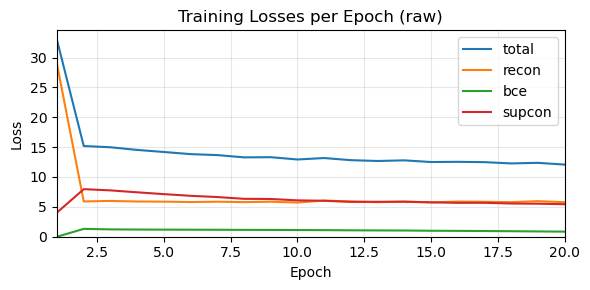

In [6]:
model, losses = train_multitask_seq_ae(
    X_train, y_train, mask_train,
    input_dim=X_train.shape[-1],
    batch_size=64,
    p_per_task=6, # ensure ≥6 positives per task per batch
    epochs=20,
    scale_warmup_epochs=1,
    lr_warmup_epochs=0,

    warmup_scales={'lambda_recon':1.0, 'lambda_bce':0.0, 'lambda_supcon':1.0},
    scales={'lambda_recon':0.2, 'lambda_bce':1, 'lambda_supcon':2.0},

    warmup_lrs={'AE':0, 'BCE':[0, 0, 0], 'SupCon':0},
    lrs={'AE':1e-3, 'BCE':[1e-3, 1e-3, 1e-4], 'SupCon':1e-3},

    latent_dim=64, 
    SupCon_latent_dim=32,

    pooling_mode ="mean+max+final", # "final", "mean+final", "mean+max+final", "mean+attn"

    weights_bce=weights_bce,
    weights_supcon=weights_supcon,
    temperature=0.07, 
    supcon_gamma=0.7,
    supcon_delta=0.5,
    seed=42
)
plot_running_total(losses) 

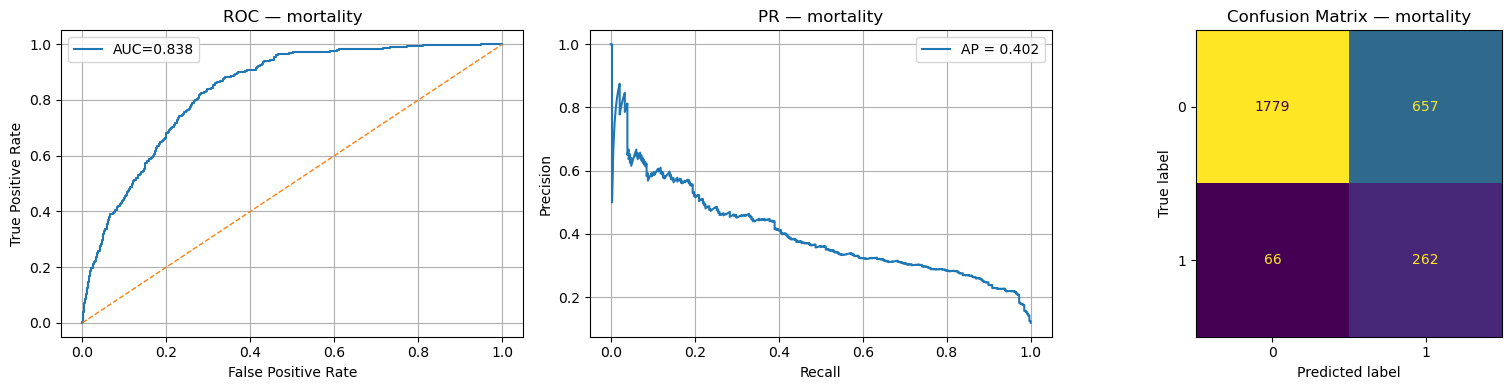

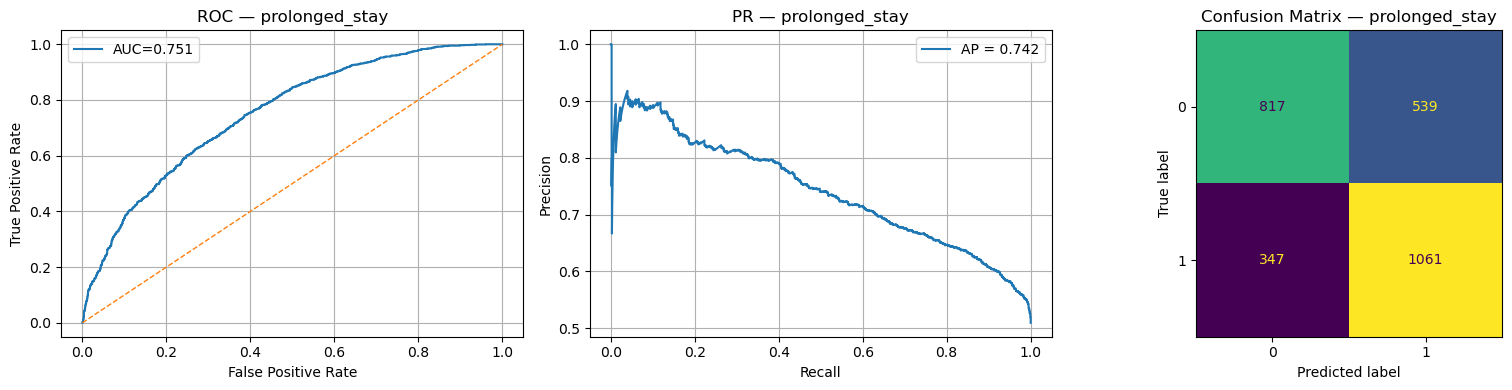

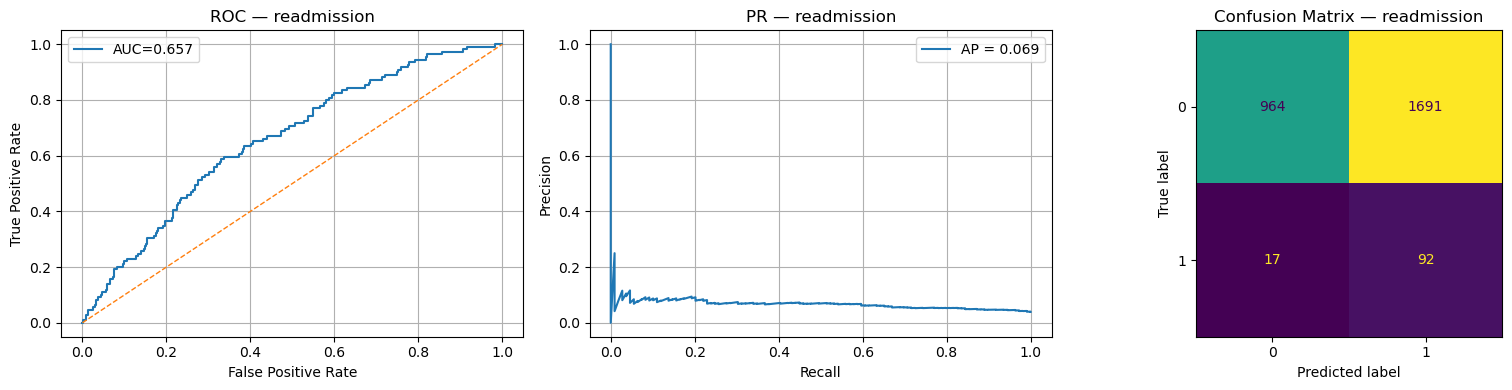

In [7]:
probs_val = predict_proba(model, X_val, mask_val)  
r_val = eval_multitask_from_probs(y_val, probs_val, task_names = TASKS, plot=True)

#### Save model

In [ ]:
import torch
torch.save(model.state_dict(), "project/model/model.pt")

# Evaluate Results

## calibration

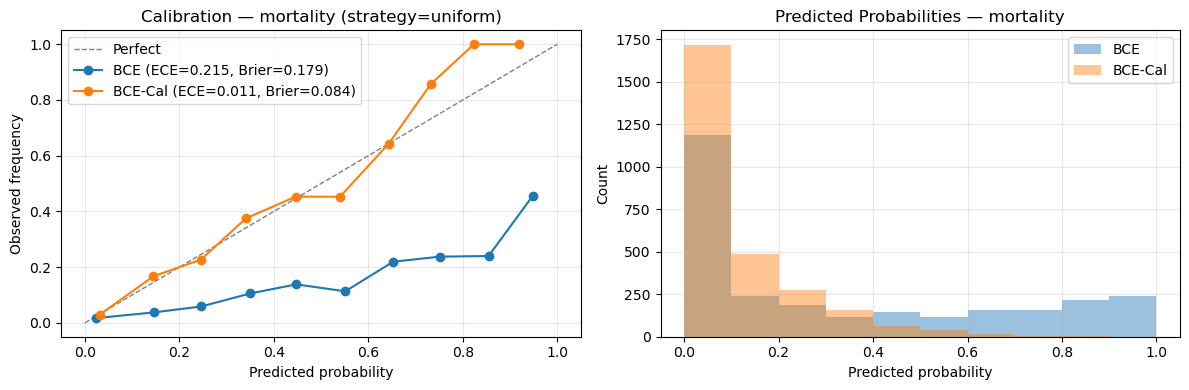

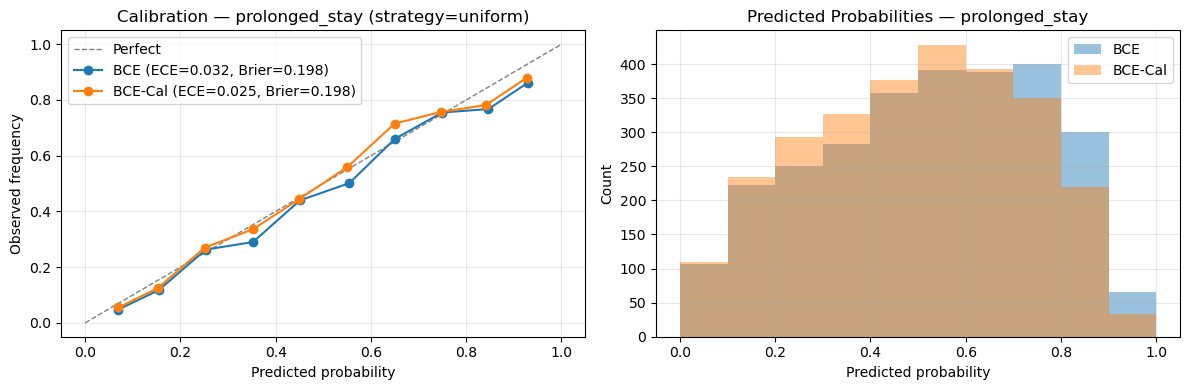

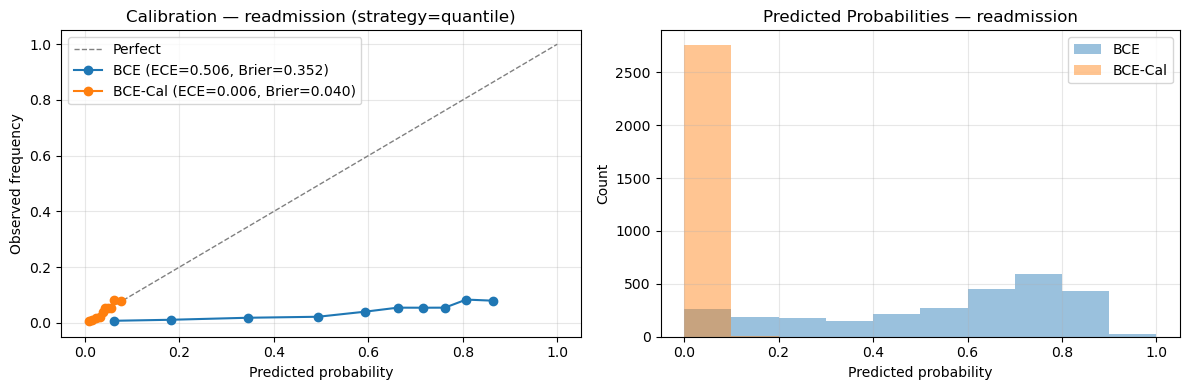

In [9]:
# compare BCE before and after calibration
val_logits = predict_logits(model, X_val, mask_val)
calibs = fit_calibrators(val_logits, y_val)
test_logits = predict_logits(model, X_test, mask_test)
probs_BCE_cal_test = predict_proba_calibrated(calibs, test_logits)

probs_BCE_test = predict_proba(model, X_test, mask_test)

probs_to_comp = [probs_BCE_test,probs_BCE_cal_test]
probs_names = ["BCE", "BCE-Cal"]

plot_calibration_curve(probs_to_comp, probs_names, y_test, task_names = TASKS)

In [10]:
probs_BCE_cal_val = predict_proba_calibrated(calibs, val_logits)
r_val = eval_multitask_from_probs(y_val, probs_BCE_cal_val, tr=0.2, task_names = TASKS, plot=False)
for i in r_val:
    print(i, r_val[i]['roc_auc'], r_val[i]['pr_auc'])

mortality 0.8382631963634907 0.4021717626639165
prolonged_stay 0.751374886866452 0.7417451044860391
readmission 0.6567770694034105 0.06883731051511692


#### save calibration

In [11]:
models_params_dict['calibrator'] = calibs
with open(f'data/models_params_dict.pkl', 'wb') as handle:
    pkl.dump(models_params_dict, handle)

## Test Evaluation

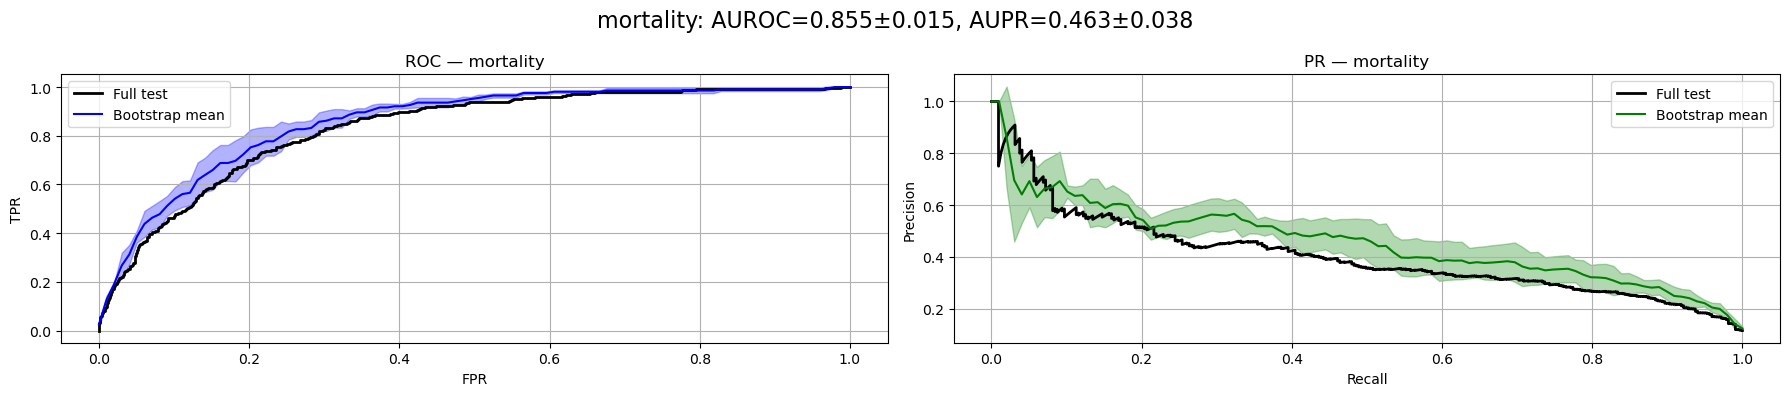

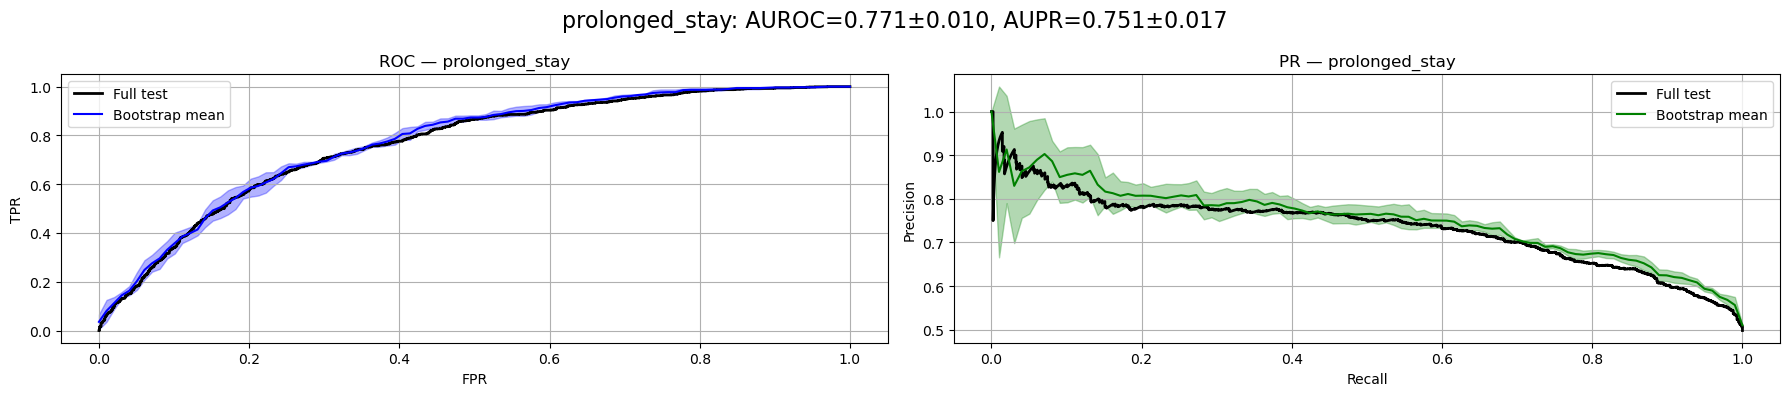

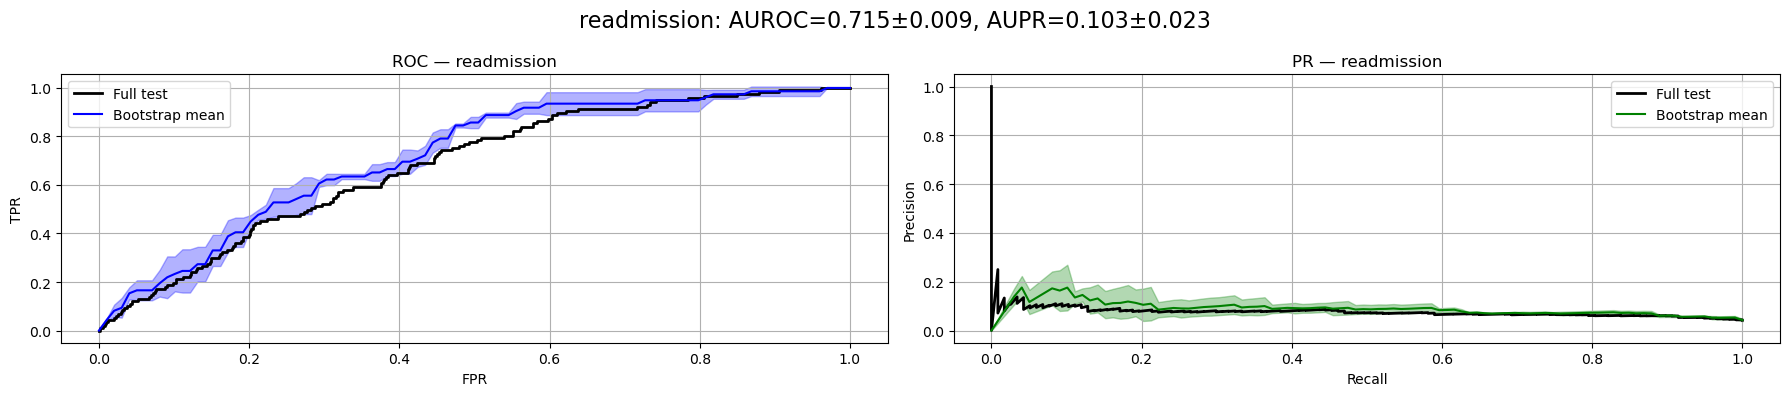

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import auc, roc_auc_score, average_precision_score, accuracy_score, f1_score, roc_curve, precision_recall_curve, confusion_matrix, precision_score, ConfusionMatrixDisplay

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# get calibrated probabilities (N, 3)
probs_all = predict_proba_calibrated(calibs, predict_logits(model, X_test, mask_test))

for i, task in enumerate(TASKS):
    probs = probs_all[:, i]
    y_true = y_test[:, i]

    # turn probs into predicted labels
    y_pred = (probs >= 0.5).astype(int)

    # full curves
    fpr_full, tpr_full, _ = roc_curve(y_true, probs)
    prec_full, rec_full, _ = precision_recall_curve(y_true, probs)
    auroc_full = auc(fpr_full, tpr_full)
    aupr_full = average_precision_score(y_true, probs)

    # bootstrap (same as before)
    tpr_list, pr_list = [], []
    aurocs, auprs = [], []
    grid = np.linspace(0, 1, 100)

    for _ in range(3):
        idx = np.random.choice(len(y_true), int(0.2 * len(y_true)), replace=True)
        fpr, tpr, _ = roc_curve(y_true[idx], probs[idx])
        prec, rec, _ = precision_recall_curve(y_true[idx], probs[idx])

        aurocs.append(auc(fpr, tpr))
        auprs.append(average_precision_score(y_true[idx], probs[idx]))

        tpr_list.append(np.interp(grid, fpr, tpr))
        pr_list.append(np.interp(grid, rec[::-1], prec[::-1]))

    mean_tpr, std_tpr = np.mean(tpr_list, axis=0), np.std(tpr_list, axis=0)
    mean_pr, std_pr = np.mean(pr_list, axis=0), np.std(pr_list, axis=0)

    # plot with 3 subplots
    fig, axes = plt.subplots(1, 2, figsize=(18, 4))

    # ROC
    axes[0].plot(fpr_full, tpr_full, color="black", lw=2, label="Full test")
    axes[0].plot(grid, mean_tpr, color="blue", label="Bootstrap mean")
    axes[0].fill_between(grid, mean_tpr - std_tpr, mean_tpr + std_tpr, color="blue", alpha=0.3)
    axes[0].set_title(f"ROC — {task}")
    axes[0].set_xlabel("FPR")
    axes[0].set_ylabel("TPR")
    axes[0].legend()
    axes[0].grid(True)

    # PR
    axes[1].plot(rec_full, prec_full, color="black", lw=2, label="Full test")
    axes[1].plot(grid, mean_pr, color="green", label="Bootstrap mean")
    axes[1].fill_between(grid, mean_pr - std_pr, mean_pr + std_pr, color="green", alpha=0.3)
    axes[1].set_title(f"PR — {task}")
    axes[1].set_xlabel("Recall")
    axes[1].set_ylabel("Precision")
    axes[1].legend()
    axes[1].grid(True)
    
    # # Confusion matrix
    # cm = confusion_matrix(y_true, y_pred)
    # ConfusionMatrixDisplay(confusion_matrix=cm).plot(ax=axes[2], colorbar=False)
    # axes[2].set_title(f"Confusion Matrix — {task}")

    fig.suptitle(f"{task}: AUROC={np.mean(aurocs):.3f}±{np.std(aurocs):.3f}, "
                 f"AUPR={np.mean(auprs):.3f}±{np.std(auprs):.3f}", fontsize=16)
    plt.tight_layout()
    plt.show()

In [103]:
import copy
BASE_ARGS = dict(batch_size=64,p_per_task=6,epochs=20,lr_warmup_epochs=0,warmup_lrs={'AE':0, 'BCE':[0, 0, 0], 'SupCon':0},lrs={'AE':1e-3, 'BCE':[1e-3, 1e-3, 1e-4], 'SupCon':1e-3},latent_dim=64,SupCon_latent_dim=32,pooling_mode="mean+max+final",temperature=0.07,supcon_gamma=0.7,supcon_delta=0.5,seed=42)

ABLATIONS = {
    # baseline (all losses on)
    "baseline": dict(scale_warmup_epochs=1, warmup_scales={'lambda_recon':1.0, 'lambda_bce':0.0, 'lambda_supcon':1}, scales={'lambda_recon':0.2, 'lambda_bce':1.0, 'lambda_supcon':2.0}),
    # remove SupCon term only
    "no_supcon": dict(scale_warmup_epochs=1, warmup_scales={'lambda_recon':1.0, 'lambda_bce':0.0, 'lambda_supcon':0.0}, scales={'lambda_recon':0.2, 'lambda_bce':1.0, 'lambda_supcon':0.0}),
    # remove Recon term only
    "no_recon": dict(scale_warmup_epochs=0, warmup_scales={'lambda_recon':0.0, 'lambda_bce':0.0, 'lambda_supcon':0.0}, scales={'lambda_recon':0.0, 'lambda_bce':1.0, 'lambda_supcon':2.0}),
    # BCE only (both Recon and SupCon off)
    "bce_only": dict(scale_warmup_epochs=0, warmup_scales={'lambda_recon':0.0, 'lambda_bce':0.0, 'lambda_supcon':0.0}, scales={'lambda_recon':0.0, 'lambda_bce':1.0, 'lambda_supcon':0.0}),
    # SupCon only (heads won’t train; use KNN for eval)
    "supcon_only": dict(scale_warmup_epochs=0, warmup_scales={'lambda_recon':0.0, 'lambda_bce':0.0, 'lambda_supcon':0.0}, scales={'lambda_recon':0.0, 'lambda_bce':0.0, 'lambda_supcon':2.0}),
}

def run_one(name, xtr, ytr, mtr, xte, yte, mte):
    # merge base args + ablation-specific overrides
    args = copy.deepcopy(BASE_ARGS)
    args.update(ABLATIONS[name])

    # train
    model, _ = train_multitask_seq_ae(
        xtr, ytr, mtr,
        input_dim=xtr.shape[-1],
        weights_bce=weights_bce,
        weights_supcon=weights_supcon,
        **args
    )
    # eval
    out = {"setting": name}

    # 1) BCE probabilities (only meaningful if lambda_bce>0)
    if args["scales"]["lambda_bce"] > 0.0:
        probs_bce = predict_proba(model, xte, mte)
        rep_bce = eval_multitask_from_probs(yte, probs_bce, plot=False, task_names=TASKS)
        for t in TASKS:
            out[f"{t}_ROC_bce"] = rep_bce[t]["roc_auc"]
            out[f"{t}_PR_bce"]  = rep_bce[t]["pr_auc"]
    else:
        for t in TASKS:
            out[f"{t}_ROC_bce"] = None
            out[f"{t}_PR_bce"]  = None

    # 2) KNN over embeddings (meaningful for all; *primary* for supcon_only)
    probs_knn = predict_proba_knn(model, xtr, xte, mtr, mte, ytr, n_neig=10)
    rep_knn = eval_multitask_from_probs(yte, probs_knn, plot=False, task_names=TASKS)
    for t in TASKS:
        out[f"{t}_ROC_knn"] = rep_knn[t]["roc_auc"]
        out[f"{t}_PR_knn"]  = rep_knn[t]["pr_auc"]

    return out

# ==== run all ====
rows = []
for name in ABLATIONS:
    rows.append(run_one(name, X_train, y_train, mask_train, X_test, y_test, mask_test))
results_df = pd.DataFrame(rows)

# pretty order
cols = ["setting"]
for src in ["bce","knn"]:
    for t in TASKS:
        cols += [f"{t}_ROC_{src}", f"{t}_PR_{src}"]
results_df = results_df[cols]

print(results_df.to_string(index=False))

    setting  mortality_ROC_bce  mortality_PR_bce  prolonged_stay_ROC_bce  prolonged_stay_PR_bce  readmission_ROC_bce  readmission_PR_bce  mortality_ROC_knn  mortality_PR_knn  prolonged_stay_ROC_knn  prolonged_stay_PR_knn  readmission_ROC_knn  readmission_PR_knn
   baseline           0.831356          0.402252                0.763355               0.732831             0.681003            0.077456           0.741562          0.306559                0.745866               0.713128             0.536098            0.050890
  no_supcon           0.794018          0.368232                0.778238               0.760146             0.602056            0.057126           0.720230          0.301052                0.718289               0.689016             0.505878            0.044806
   no_recon           0.838854          0.424749                0.767930               0.740561             0.681636            0.077484           0.759048          0.312457                0.738552               0.

# feature importance

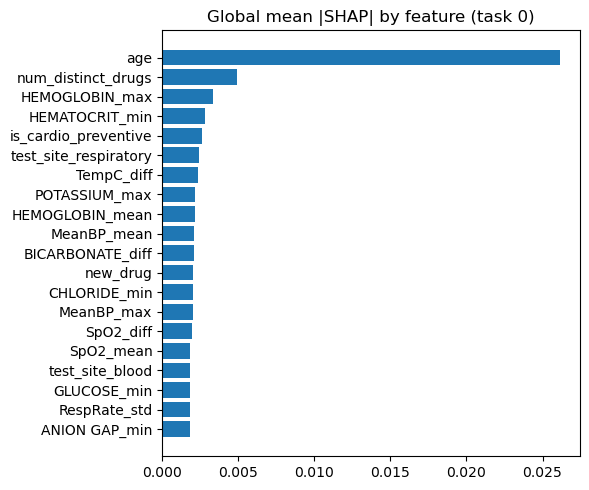

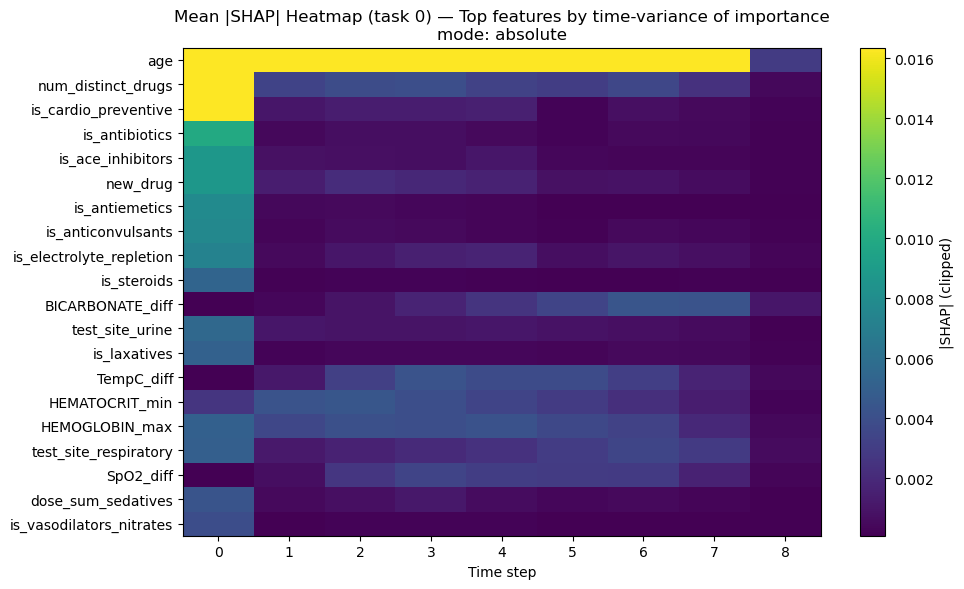

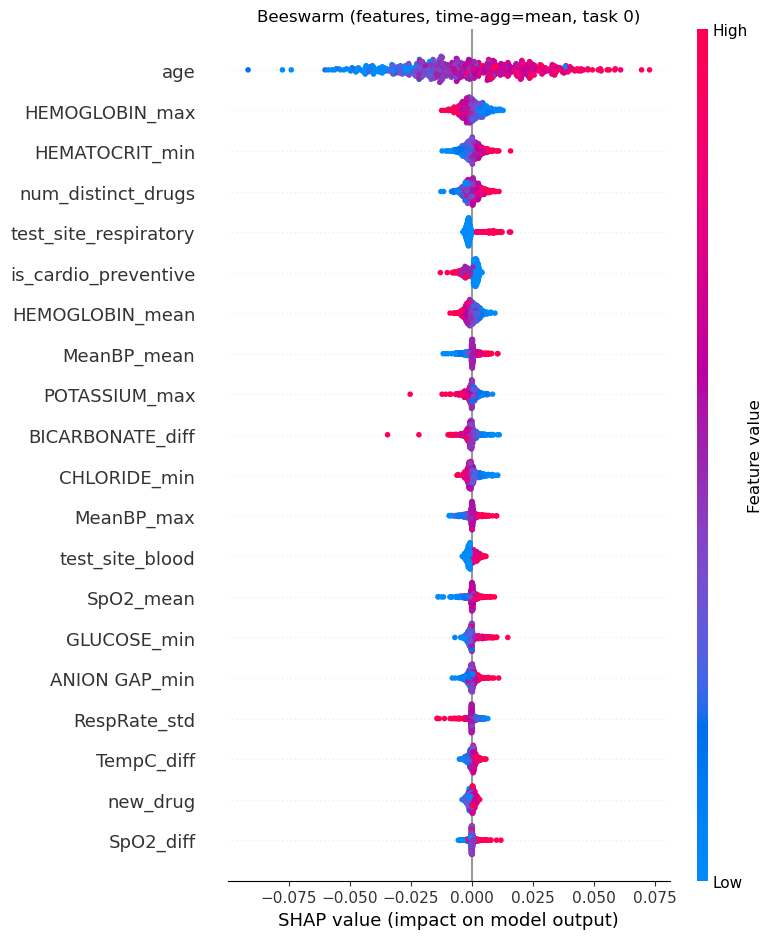

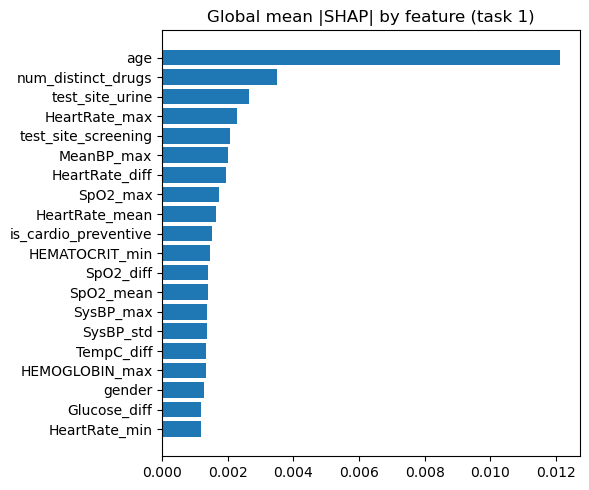

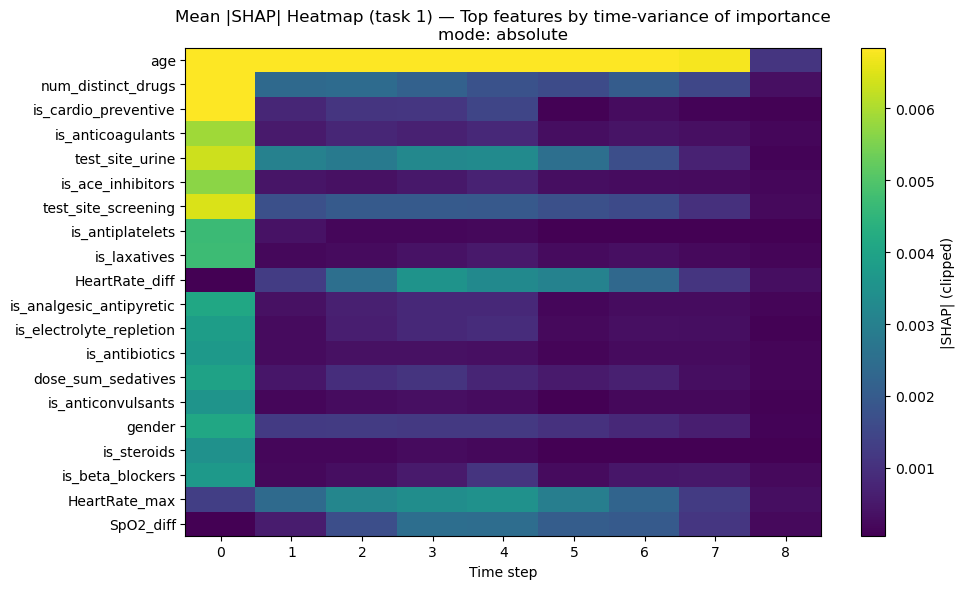

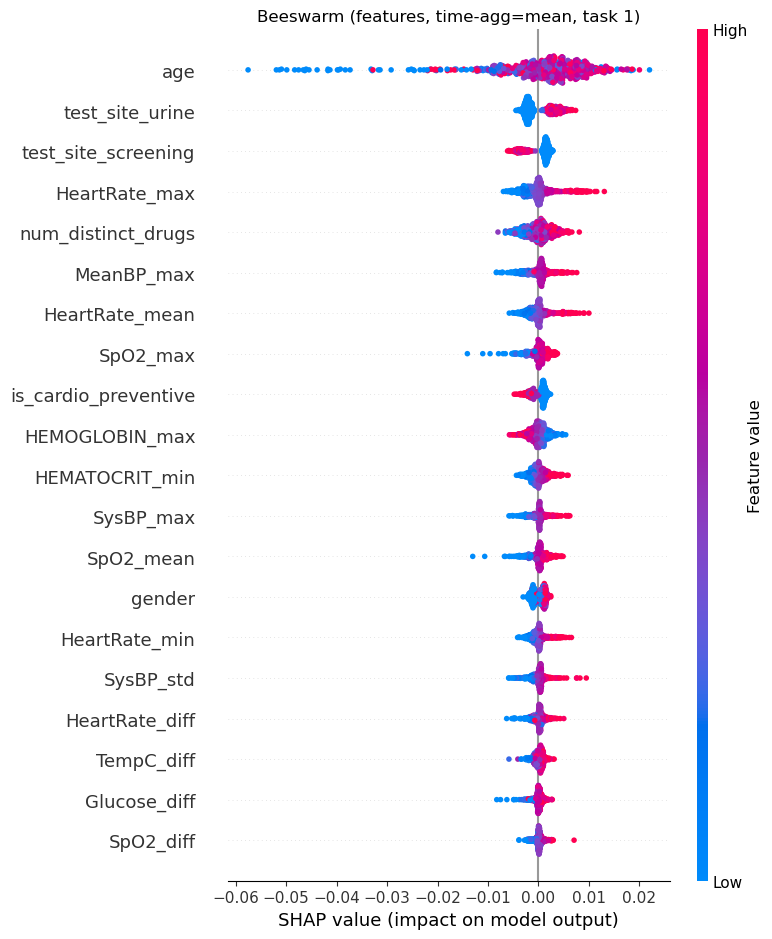

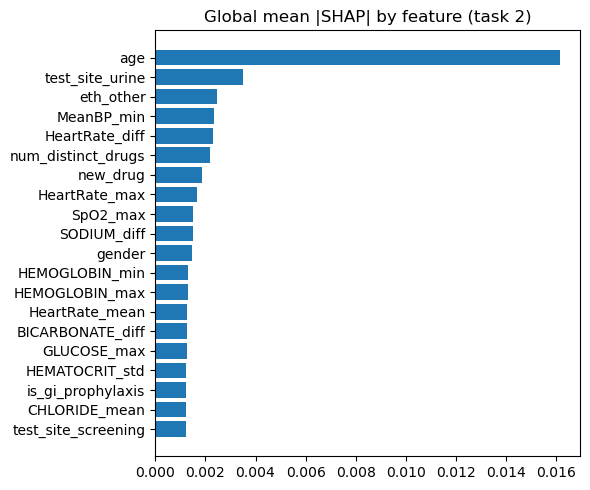

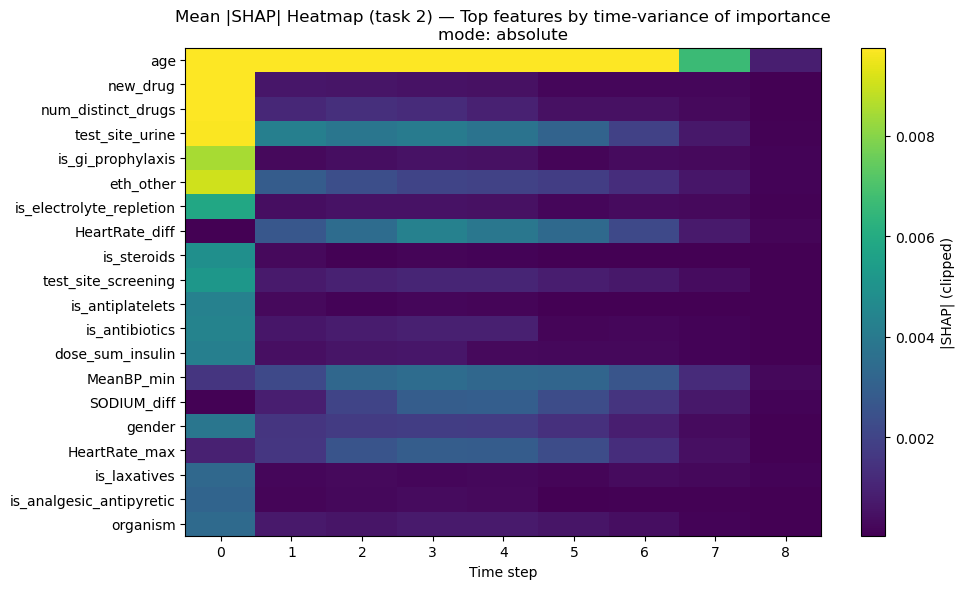

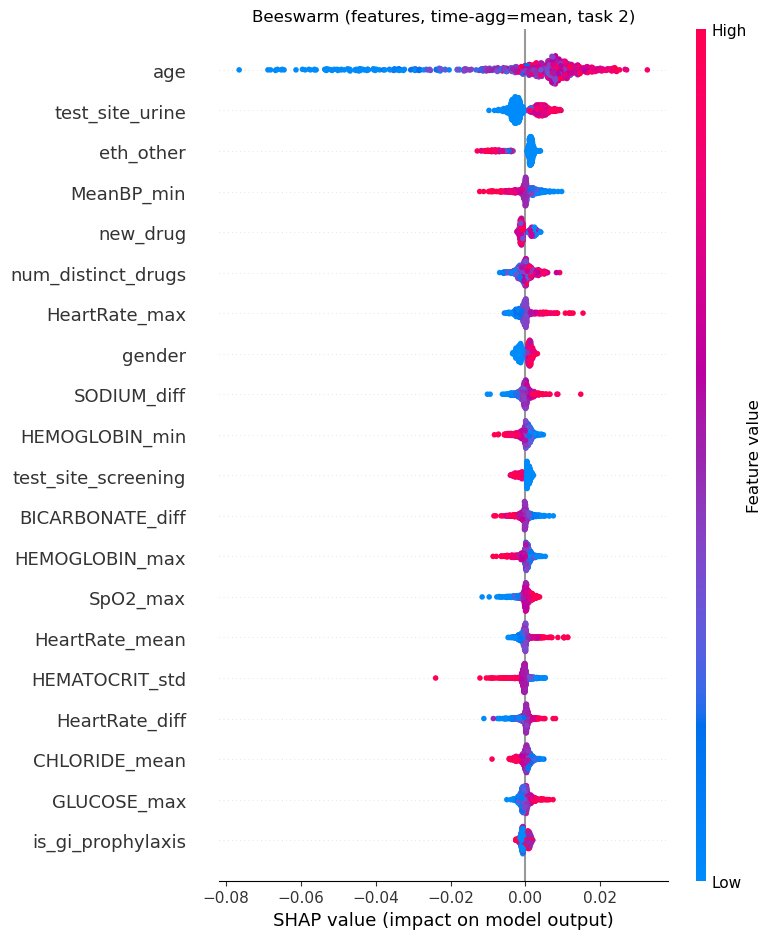

In [23]:
feature_importance_res = []

for i in range(3):
    feature_importance_res.append(feature_importance(
        model, task_idx=i, X_train=X_train, y_train=y_train, mask_train=mask_train, X_test=X_test, y_test=y_test, mask_test=mask_test, 
        fnames=models_params_dict['train_features'], topk=20,
        heatmap_mode="absolute", select_for_heatmap="time_var", time_agg="mean"))

# Fairness Evaluation

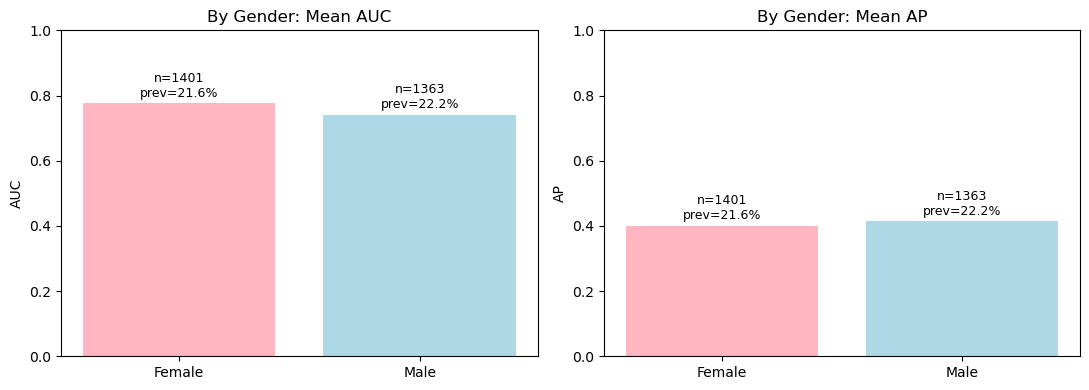

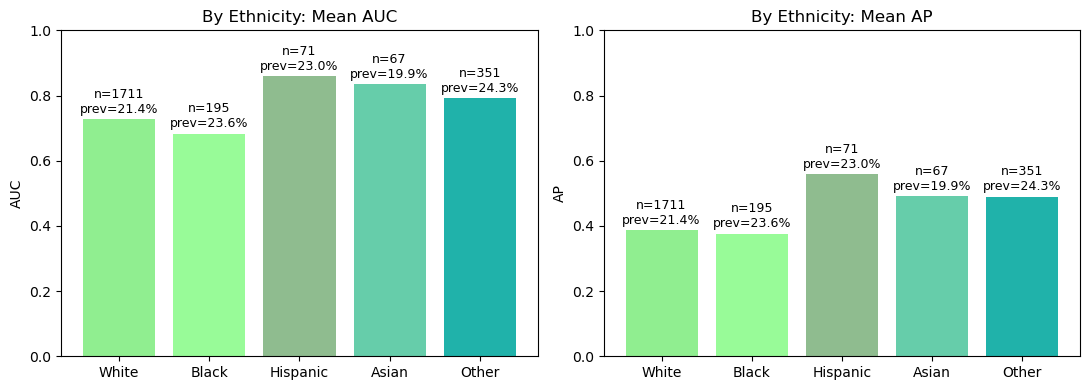

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

probs_all = predict_proba_calibrated(calibs, predict_logits(model, X_test, mask_test))

# ethnicity one-hots at indices 2..6: white, black, hispanic, asian, other (exact order below)
ETH_IDX = {
    "White":   2,
    "Black":   3,
    "Hispanic":4,
    "Asian":   5,
    "Other":   6,
}
# gender feature index = 0  (encoded M->1, F->0)
GENDER_IDX = 0

def _static_binary_from_time(x_3d, feat_idx):
    """
    For a (N,T,F) tensor and a binary feature index, return a per-subject binary vector.
    We take the time-mean and round, which is robust if values are constant or mostly constant over time.
    """
    col = x_3d[:, :, feat_idx]                              # (N, T)
    m = np.nanmean(col, axis=1)                             # (N,)
    return np.round(m)                                      # {0,1} with NaN -> nan; we'll mask those

def _eval_group(mask_bool, group_name):
    mask_bool = np.asarray(mask_bool).astype(bool)
    n = int(mask_bool.sum())
    if n == 0:
        return dict(name=group_name, mean_auc=np.nan, mean_ap=np.nan, n=0, mean_prev=np.nan)
    y_sub = y_test[mask_bool]
    p_sub = probs_all[mask_bool]
    r = eval_multitask_from_probs(y_sub, p_sub, tr=0.2, task_names=TASKS, plot=False)
    mean_auc = float(np.mean([r[t]['roc_auc'] for t in TASKS]))
    mean_ap  = float(np.mean([r[t]['pr_auc'] for t in TASKS]))
    # mean prevalence across tasks (simple overall average of the 3 heads)
    mean_prev = float(np.mean(y_sub))  # average of all entries in y_sub
    return dict(name=group_name, mean_auc=mean_auc, mean_ap=mean_ap, n=n, mean_prev=mean_prev)

# build subgroup masks by index
gender_vals = _static_binary_from_time(X_test, GENDER_IDX)      # 1=Male, 0=Female
gender_valid = np.isfinite(gender_vals)

gender_groups = {
    "Female": gender_valid & (gender_vals == 0),
    "Male":   gender_valid & (gender_vals == 1),
}

eth_groups = {}
for eth_name, idx in ETH_IDX.items():
    eth_val = _static_binary_from_time(X_test, idx)              # one-hot per subject
    eth_groups[eth_name] = np.isfinite(eth_val) & (eth_val == 1)

# eval per subgroup
gender_results = [_eval_group(mask, name) for name, mask in gender_groups.items()]
eth_results    = [_eval_group(mask, name) for name, mask in eth_groups.items()]

# plot helpers
import matplotlib.pyplot as plt

def _barplot(results, title_prefix, colors=None):
    names      = [r["name"] for r in results]
    mean_auc   = [r["mean_auc"] for r in results]
    mean_ap    = [r["mean_ap"] for r in results]
    ns         = [r["n"] for r in results]
    prevalences= [r["mean_prev"] for r in results]  # 0..1

    fig, axes = plt.subplots(1, 2, figsize=(11, 4))
    for ax, vals, metric in zip(axes, [mean_auc, mean_ap], ["AUC", "AP"]):
        if colors is None:
            bars = ax.bar(names, vals)
        else:
            bars = ax.bar(names, vals, color=colors)
        ax.set_title(f"{title_prefix}: Mean {metric}")
        ax.set_ylabel(metric)
        ax.set_ylim(0, 1)
        # annotate n and prevalence on each bar
        for b, n, prev in zip(bars, ns, prevalences):
            h = b.get_height()
            label = f"n={n}\nprev={prev*100:.1f}%"
            ax.text(b.get_x() + b.get_width()/2, h + 0.01, label,
                    ha='center', va='bottom', fontsize=9)
        ax.tick_params(axis='x', rotation=0)
    plt.tight_layout()
    return fig

gender_colors = ["#FFB6C1", "#ADD8E6"]  # light pink, light blue
eth_colors    = ["#90EE90", "#98FB98", "#8FBC8F", "#66CDAA", "#20B2AA"]  # light green family

_ = _barplot(gender_results, "By Gender", colors=gender_colors)
_ = _barplot(eth_results,    "By Ethnicity", colors=eth_colors)
plt.show()
